In [1]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import json
import fiona
import sys
import getpass
import requests
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

user = getpass.getuser()
sys.dont_write_bytecode = True

sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

In [2]:
data_dir = '../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

# RHNA Site Selection Pre-Screening Dataset Processing

## Approach

Develop a parcel-level dataset containing factors required by HCD as well as optional factors such as whether the site is located within a high opportunity area, or a transportation priority area, any floor area ratio requirements of the site, etc. The dataset will be developed from a combination of publically available datasets as well as datasets developed by MTC/ABAG from local governments and counties throughout the Bay Area.

## Data Sources

**[Data Sources Inventory](https://mtcdrive.app.box.com/file/700718735166)**

### Create housing sites dataset on socrata

In [5]:
dataset_name= 'Housing Element Site Selection Parcels'
dataset_desc= 'This dataset contains regional parcels from 2018 with factors used to support development of a site selection pre-screening tool'
columns = [{'fieldName': 'joinid', 'name': 'joinid' , 'dataTypeName': 'text'},
          {'fieldName': 'fipco', 'name': 'county_fips' , 'dataTypeName': 'text'},
          {'fieldName': 'jurisdict', 'name': 'jurisdiction' , 'dataTypeName': 'text'},
          {'fieldName': 'apn_frm', 'name': 'apn_formatted' , 'dataTypeName': 'text'},
          {'fieldName': 'acres', 'name': 'acres' , 'dataTypeName': 'number'},
           {'fieldName': 'exist_lu', 'name': 'existing_land_use' , 'dataTypeName': 'text'},
           {'fieldName': 'plu_zoning', 'name': 'planned_lu_zoning' , 'dataTypeName': 'text'},
           {'fieldName': 'plu_gp', 'name': 'planned_lu_general_plan' , 'dataTypeName': 'text'},
           {'fieldName': 'public_own', 'name': 'public_ownership' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr', 'name': 'fair_market_rent' , 'dataTypeName': 'number'},
          {'fieldName': 'tract_geoi', 'name': 'tract_geoid' , 'dataTypeName': 'text'},
           {'fieldName': 'block_geoi', 'name': 'block_geoid' , 'dataTypeName': 'text'},
           {'fieldName': 'resi_level', 'name': 'hcd_community_resource_level' , 'dataTypeName': 'text'},
           {'fieldName': 'fire_risk', 'name': 'calfire_fire_risk' , 'dataTypeName': 'text'},
           {'fieldName': 'sea_level', 'name': 'bcdc_sea_level_rise' , 'dataTypeName': 'number'},
           {'fieldName': 'cpad', 'name': 'cal_protected_area_database' , 'dataTypeName': 'number'},
           {'fieldName': 'urban_serv', 'name': 'urban_service_area' , 'dataTypeName': 'number'},
           {'fieldName': 'tra', 'name': 'transit_rich_area' , 'dataTypeName': 'number'},
           {'fieldName': 'rhna_5', 'name': 'rhna_5' , 'dataTypeName': 'number'},
           {'fieldName': 'rhna_4', 'name': 'rhna_4' , 'dataTypeName': 'number'},
           {'fieldName': 'bldg_permi', 'name': 'bldg_permi' , 'dataTypeName': 'number'},
           {'fieldName': 'vmt', 'name': 'vehicle_miles_traveled' , 'dataTypeName': 'number'},
           {'fieldName': 'x_centroid', 'name': 'x_centroid' , 'dataTypeName': 'number'},
           {'fieldName': 'y_centroid', 'name': 'y_centroid' , 'dataTypeName': 'number'},
          {'fieldName': 'geometry', 'name': 'geometry' , 'dataTypeName': 'multipolygon'}]
category= 'Land & People'
tags = ['housing','housing element','site selection','hcd','housing and community development','rhna']
row_identifier='joinid'
create_socrata_dataset(dataset_name,dataset_desc,columns,category,tags,row_identifier)

created dataset on Socrata with id: js6f-hc9f


{'id': 'js6f-hc9f',
 'name': 'Housing Element Site Selection Parcels',
 'averageRating': 0,
 'category': 'Land & People',
 'createdAt': 1597114828,
 'description': 'This dataset contains regional parcels from 2018 with factors used to support development of a site selection pre-screening tool',
 'displayType': 'table',
 'downloadCount': 0,
 'hideFromCatalog': False,
 'hideFromDataJson': False,
 'newBackend': True,
 'numberOfComments': 0,
 'oid': 34915233,
 'provenance': 'official',
 'publicationAppendEnabled': False,
 'publicationGroup': 17431033,
 'publicationStage': 'unpublished',
 'rowIdentifierColumnId': 487265506,
 'rowsUpdatedAt': 1597114828,
 'tableId': 17431033,
 'totalTimesRated': 0,
 'viewCount': 0,
 'viewLastModified': 1597114830,
 'viewType': 'tabular',
 'columns': [{'id': 487265506,
   'name': 'joinid',
   'dataTypeName': 'text',
   'fieldName': 'joinid',
   'position': 1,
   'renderTypeName': 'text',
   'tableColumnId': 111651495,
   'format': {}},
  {'id': 487265507,
   

In [6]:
#Socrata housing site selection db 4x4
housing_site_db_id = 'js6f-hc9f'

### Pull regional parcel data from Socrata as geojson

In [ ]:
parcel_geojson = pull_geojson_from_socrata('pu8t-xzre')

pulling 2142255 rows as geojson


In [ ]:
parcel_geojson['features']

In [ ]:
# Convert to geojson to geodataframe
parcel_columns = ['joinid',
                  'fipco',
                  'jurisdict',
                  'apn_frm',
                  'acres',
                  'geometry']
parcels = gp.GeoDataFrame.from_features(parcel_geojson['features'],columns=parcel_columns,crs={'init': 'epsg:4326'})

In [ ]:
parcels.crs

In [ ]:
parcels.info()

In [19]:
# Project parcels for later area overlay work
parcels_nad83 = parcels.to_crs(epsg='26910')

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [20]:
# Create area column for later overlay work
parcels_nad83['parcel_area'] = parcels_nad83['geometry'].area

### Query Census TIGER Tracts to get Bay Area Census Tracts
#### [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)

This is a pre-step for later work. Many of the overlay datasets contant Census tract geography level data. This step will create a crosswalk between parcels and Census tracts, using a 'maximal overlay' method. 

- Where a given parcel is split by a census tract, the parcel will get the GEOID of the largest intersecting area. 

In [21]:
state = "'06'"
counties = "('001','013','041','055','075','081','085','095','097')"
url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/3/query?where=STATE={state}+AND+COUNTY+IN{counties}&outFields=GEOID&f=geojson'.format(state=state,counties=counties)

In [22]:
print(url)

https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/3/query?where=STATE='06'+AND+COUNTY+IN('001','013','041','055','075','081','085','095','097')&outFields=GEOID&f=geojson


In [25]:
geo_rq = requests.get(url)
tracts_json = geo_rq.json()

In [28]:
tracts_2018 = gp.GeoDataFrame.from_features(tracts_json['features'],crs=tracts_json['crs']['properties']['name'])

In [29]:
tracts_2018.crs

'EPSG:4326'

In [34]:
#project to NAD83 UTMZ10N 
tracts_nad83_2018 = tracts_2018.to_crs(epsg='26910')

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [35]:
tracts_nad83_2018.crs

{'init': 'epsg:26910', 'no_defs': True}

In [36]:
tracts_nad83_2018.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1582 entries, 0 to 1581
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1582 non-null   geometry
 1   GEOID     1582 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 24.8+ KB


In [37]:
tracts_nad83_2018.head(5)

,geometry,GEOID
0,"POLYGON ((566221.610 4193371.510, 566230.454 4...",06001400100
1,"POLYGON ((565335.837 4188666.188, 565291.836 4...",06001400200
2,"POLYGON ((564744.993 4188317.651, 564617.972 4...",06001400300
3,"POLYGON ((563531.244 4189141.694, 563523.259 4...",06001400700
4,"POLYGON ((562575.022 4189406.534, 562653.620 4...",06001400800


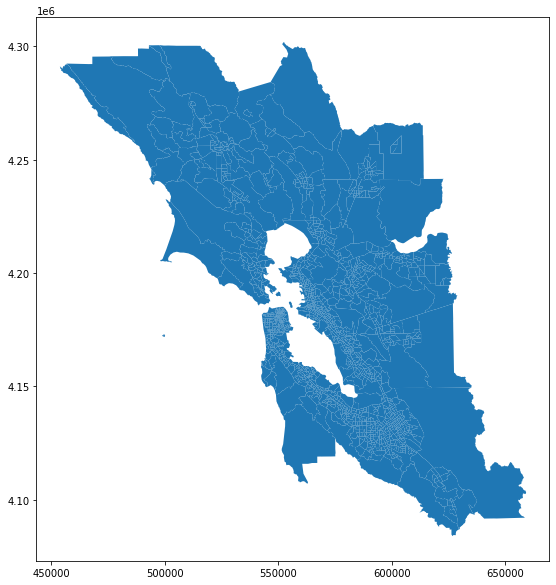

In [39]:
tracts_nad83_2018.plot(figsize=(10,10));

In [40]:
#Perform overlay on parcels and tracts
parcels_tracts = gp.overlay(parcels_nad83,tracts_nad83_2018,how='intersection')

In [41]:
parcels_tracts.head(5)

,joinid,fipco,jurisdict,apn_frm,acres,parcel_area,GEOID,geometry
0,AL000001,CA001,Oakland,48-6298-68,0.624495957805855,2527.247971,06001409900,"POLYGON ((577484.450 4179131.291, 577447.475 4..."
1,AL000002,CA001,Oakland,48-6298-3-2,0.149729127668363,605.931046,06001409900,"POLYGON ((577178.793 4179073.245, 577149.444 4..."
2,AL000003,CA001,Oakland,48-6299-71,0.163234864052674,660.589139,06001409900,"POLYGON ((577235.731 4178674.276, 577209.595 4..."
3,AL000004,CA001,Oakland,48-6313-23,0.267472543150323,1082.425616,06001409900,"POLYGON ((577074.180 4178914.001, 577060.690 4..."
4,AL000005,CA001,Oakland,48-6432-39,0.401868448364306,1626.304574,06001409900,"POLYGON ((576758.579 4179818.295, 576715.002 4..."


In [42]:
#Calculate overlay area
parcels_tracts['area_overlay'] = parcels_tracts['geometry'].area

In [44]:
#Calculate overlay ratio
parcels_tracts['pct_overlay'] = parcels_tracts['parcel_area'] / parcels_tracts['area_overlay']

In [45]:
parcels_tracts.head(5)

,joinid,fipco,jurisdict,apn_frm,acres,parcel_area,GEOID,geometry,area_overlay,pct_overlay
0,AL000001,CA001,Oakland,48-6298-68,0.624495957805855,2527.247971,06001409900,"POLYGON ((577484.450 4179131.291, 577447.475 4...",2527.247971,1.0
1,AL000002,CA001,Oakland,48-6298-3-2,0.149729127668363,605.931046,06001409900,"POLYGON ((577178.793 4179073.245, 577149.444 4...",605.931046,1.0
2,AL000003,CA001,Oakland,48-6299-71,0.163234864052674,660.589139,06001409900,"POLYGON ((577235.731 4178674.276, 577209.595 4...",660.589139,1.0
3,AL000004,CA001,Oakland,48-6313-23,0.267472543150323,1082.425616,06001409900,"POLYGON ((577074.180 4178914.001, 577060.690 4...",1082.425616,1.0
4,AL000005,CA001,Oakland,48-6432-39,0.401868448364306,1626.304574,06001409900,"POLYGON ((576758.579 4179818.295, 576715.002 4...",1626.304574,1.0


In [46]:
parcels_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2180367 entries, 0 to 2180366
Data columns (total 10 columns):
 #   Column        Dtype   
---  ------        -----   
 0   joinid        object  
 1   fipco         object  
 2   jurisdict     object  
 3   apn_frm       object  
 4   acres         object  
 5   parcel_area   float64 
 6   GEOID         object  
 7   geometry      geometry
 8   area_overlay  float64 
 9   pct_overlay   float64 
dtypes: float64(3), geometry(1), object(6)
memory usage: 166.3+ MB


In [190]:
#Find maximal overlay of tracts with parcels
parcels_tracts_max_overlay = parcels_tracts.iloc[parcels_tracts.groupby(['joinid'])['pct_overlay'].idxmax()].copy()

In [191]:
parcels_tracts_max_overlay.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2141080 entries, 0 to 2121844
Data columns (total 10 columns):
 #   Column        Dtype   
---  ------        -----   
 0   joinid        object  
 1   fipco         object  
 2   jurisdict     object  
 3   apn_frm       object  
 4   acres         object  
 5   parcel_area   float64 
 6   GEOID         object  
 7   geometry      geometry
 8   area_overlay  float64 
 9   pct_overlay   float64 
dtypes: float64(3), geometry(1), object(6)
memory usage: 179.7+ MB


In [192]:
#Join parcel overlay subset back to full set of parcels
parcels_tracts_max_overlay_full = pd.merge(parcels,
                                           parcels_tracts_max_overlay[['joinid','GEOID']],
                                          on='joinid',
                                          how='left')

In [193]:
#Rename columns before upsert to socrata
columns = {'GEOID': 'census_geoid'}
parcels_tracts_max_overlay_full.rename(columns=columns,inplace=True)

In [194]:
parcels_tracts_max_overlay_full.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142255 entries, 0 to 2142254
Data columns (total 7 columns):
 #   Column        Dtype   
---  ------        -----   
 0   joinid        object  
 1   fipco         object  
 2   jurisdict     object  
 3   apn_frm       object  
 4   acres         object  
 5   geometry      geometry
 6   census_geoid  object  
dtypes: geometry(1), object(6)
memory usage: 130.8+ MB


In [195]:
#Convert geom type from polygon to multipolygon before upsert
parcels_tracts_max_overlay_full['geometry']= [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in parcels_tracts_max_overlay_full["geometry"]]

In [196]:
#Convert geometry to wkt format before upserting to socrata
parcels_tracts_max_overlay_full['geometry'] = parcels_tracts_max_overlay_full['geometry'].map(lambda x: x.wkt)

In [197]:
parcels_tracts_max_overlay_full.head(10)

,joinid,fipco,jurisdict,apn_frm,acres,geometry,census_geoid
0,AL000001,CA001,Oakland,48-6298-68,0.624495957805855,MULTIPOLYGON (((-122.120375004 37.756214616000...,06001409900
1,AL000002,CA001,Oakland,48-6298-3-2,0.149729127668363,MULTIPOLYGON (((-122.1238506989999 37.75571733...,06001409900
2,AL000003,CA001,Oakland,48-6299-71,0.163234864052674,MULTIPOLYGON (((-122.1232468379999 37.75211693...,06001409900
3,AL000004,CA001,Oakland,48-6313-23,0.267472543150323,MULTIPOLYGON (((-122.125055068 37.754291018000...,06001409900
4,AL000005,CA001,Oakland,48-6432-39,0.401868448364306,MULTIPOLYGON (((-122.128541781 37.762467257000...,06001409900
5,AL000006,CA001,Oakland,48-6432-51,0.422807899660084,MULTIPOLYGON (((-122.127357392 37.763071106000...,06001409900
6,AL000007,CA001,Oakland,48-6431-7,0.204664264932627,MULTIPOLYGON (((-122.1316201499999 37.76050719...,06001409900
7,AL000008,CA001,Oakland,48-6313-25,0.274377949904205,MULTIPOLYGON (((-122.124571039 37.754339969000...,06001409900
8,AL000009,CA001,Oakland,48-6313-87,0.137672686739755,MULTIPOLYGON (((-122.126366686 37.753668080000...,06001409900
9,AL000010,CA001,Oakland,48-6298-60,0.163036237080993,MULTIPOLYGON (((-122.121958935 37.756413339000...,06001409900


In [198]:
#Upsert to socrata w/ geoid
upsert_df_socrata(parcels_tracts_max_overlay_full[['joinid',
                                              'fipco',
                                              'jurisdict',
                                              'apn_frm',
                                              'acres',
                                              'census_geoid',
                                              'geometry']],housing_site_db_id)

upserting data to Socrata in 15 chunks of 143000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
data upserted to t9zc-bu3x
took 11.0397 minutes
